In [15]:
import pandas as pd
import numpy as np
from time import process_time
import ast
import re
import regex
import csv
from string import punctuation
from nltk.stem import WordNetLemmatizer
import unicodedata
from collections import OrderedDict 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

%matplotlib notebook

# Read and Preprocess data

In [16]:
class Preprocess:
        
    # --------------------------------------- Constructor ------------------------------------------------

    def __init__(self):
        file = open("../marathi-stopwords.txt")
        self.stopword_list = []
        for row in file:
            self.stopword_list.append(re.sub('\n', '', row))


    # --------------------------------------- Clean Data -------------------------------------------------    
    
    def read_data(self, path):
        return pd.read_csv(path)

    
    # --------------------------------------- Expand concatenations --------------------------------------

    def expand_concatenations(self, word):
        if re.match('[a-zA-Z]+', word):
            for i in range(len(word)):
                if('DEVANAGARI ' in unicodedata.name(word[i])):
                    word = word[i:] if( len(word[:i]) < 2 ) else word[:i] + " " + word[i:]
                    break
        return(word)


    # --------------------------------------- Preprocess -------------------------------------------------

    def preprocess_data(self, text):

        # Cleaning the urls
        text = re.sub(r'https?://\S+|www\.\S+', '', str(text))

        # Cleaning the html elements
        text = re.sub(r'<.*?>', '', text)

        # Removing the punctuations
        text = re.sub('[!#?,.:";-@#$%^&*_~<>()-]', ' ', text)

        # Removing stop words
        text = [word for word in text.split() if word not in self.stopword_list]

        # Expanding noisy concatenations (Eg: algorithmआणि  -> algorithm आणि ) 
        text = [self.expand_concatenations(word) for word in text]

        preprocessed_text = ""
        lemmatizer = WordNetLemmatizer()
        for word in text: 
            if (re.match('\d+', word)):
                if(word.isnumeric()):
                    preprocessed_text = preprocessed_text + '<Numeric>' + " "

            else:
                if(re.match('[a-zA-Z]+', word)):
                    word = word.lower()
    #                             word = lemmatizer.lemmatize(word, pos='v')
                    preprocessed_text = preprocessed_text + word + " "

                else:
                    preprocessed_text = preprocessed_text + word + " "

        return preprocessed_text.strip()

In [17]:
obj = Preprocess()

In [18]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = obj.read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [19]:
training_data['text'] = training_data.text.apply(lambda x: obj.preprocess_data(x))
training_data

,text,label
0,प्रा प्रताप हरिदास मला वाटते महत्त्वाचा मुद्दा...,com_tech
1,विशिष्ट गोष्टींद्वारे ठराविक कायद्यांद्वारे वि...,bioche
2,डेटा कुठे स्थित जेथे विस्तार इत्यादी गोष्टींवर...,cse
3,आपला अर्धा चिन्ह <Numeric> वाजता असेल,phy
4,म्हणालो जर शेकडो हजारो किंवा लाखो विंडील्स बाह...,phy
...,...,...
41992,डेटा कूटबद्ध तरीही मुख्य व्यवस्थापन गोष्टींवर ...,cse
41993,म्हणतात ज्याला पाहण्यासाठी डोळे ऎकण्यासाठी कान...,com_tech
41994,प्रथम क्रोनोलॉजिकल क्रॉनोलॉजी आपल्याला अर्थ मा...,com_tech
41995,थोड्या तपशीलावर येईल जेणेकरून संपूर्ण गोष्टींच...,bioche


In [20]:
x_train = training_data.text.values.tolist()
y_train = training_data.label.values.tolist()

In [22]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = obj.read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [23]:
val_data['text'] = val_data.text.apply(lambda x: obj.preprocess_data(x))
val_data

,text,label
0,<Numeric> ची ओळ,cse
1,टॉवर टॉवरवर निश्चित जाते नखेला जोडली जाते नंतर...,phy
2,थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी पर्थ...,cse
3,लोक शोधत आहात आपल्यासाठी काहीतरी करू शकतात,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये तंत्र असण्याचे ...,cse
...,...,...
3775,नंतर वृद्धत्व व्हॉट मोठ्या प्रमाणात फ्रॉन <Num...,bioche
3776,सुद्धा आपल्याला सेकंदांनंतर माहित असेल जमिनीवर...,phy
3777,elf शीर्षलेखासह प्रारंभ करू,cse
3778,क्रॉस्टची जाडी,phy


In [24]:
x_val = val_data.text.values.tolist()
y_val = val_data.label.values.tolist()

# Tokenize Data

In [25]:
def custom_analyzer(text):
    # extract words of at least 1 letters
    words = regex.findall(r'\w{1,}', text)
    for w in words:
        yield w

        
def bow_vectorize(x_train, x_val):
        bow_vectorizer = CountVectorizer(analyzer=custom_analyzer)
        bow_vectorizer.fit(x_train)
        bow_x_train = bow_vectorizer.transform(x_train)
        bow_x_val = bow_vectorizer.transform(x_val)
        return bow_vectorizer, bow_x_train, bow_x_val

In [26]:
bow_vectorizer, bow_x_train, bow_x_val = bow_vectorize(x_train, x_val)
print(bow_x_train.shape)
print(bow_x_val.shape)

(41997, 51841)
(3780, 51841)


In [38]:
def analyze_vocab(vocab_words):
    numbers = []
    english_words = []
    marathi_words = []
    for word in vocab_words:
        #if any(map(str.isdigit, word)):
        if re.match('\d+', word):
            numbers.append(word)
        elif re.match('[a-zA-Z]+', word):
            english_words.append(word)
        else:
            marathi_words.append(word)
    return numbers, english_words, marathi_words

In [39]:
vocab_words = bow_vectorizer.get_feature_names()

In [40]:
print("Total Vocabulary: ", len(vocab_words))
numbers, english_words, marathi_words = analyze_vocab(vocab_words)
print(len(numbers))
print(len(english_words))
print(len(marathi_words))

Total Vocabulary:  51841
5
930
50906


In [44]:
for t in x_train:
    for w in t.split():
        if w in numbers:
            print(t)

उपकरणे पृथ्वीच्या पृष्ठभागावर बसलेली प्रमाणात उपकरणांपर्यंत पोहोचत with १ टक्क्यांशी व्यवहार करीत
<Numeric> <Numeric> <Numeric> <Numeric> टक्के रेडिएशन संबोधले गेले वातावरणाशी पृथ्वीच्या सापेक्ष वेगवेगळ्या घटनांमध्ये सहभागी जर टक्के आपल्याला <Numeric> टक्के सोडते सूर्यापासून निघालेले विकिरण <Numeric> टक्के जमीन पाणी शोषून घेत दररोज सूर्यापासून पृथ्वीवर येणारा सूर्यप्रकाश त्यातील percent टक्के किंवा थोडेसे over टक्क्यांहून त्यातील percent १ टक्के ग्रह पृथ्वीच्या पृष्ठभागावर पोचतात ज्या पृष्ठभागावर उभे आहोत
जर तुम्ही सूर्यापासून सर्वात जवळील बिंदू खांबाच्या दिशेला ठिकाणाहून आपल्यास <Numeric> kilometers ०० किलोमीटर अंतरावर हलवत असाल सूर्यकाशाच्या दिशेने किती दूर जाऊ त्रिज्याचे अंतर
आधीच <Numeric> टक्के <Numeric> टक्के फक्त प्रतिबिंबित आपल्याकडे फक्त उर्वरित टक्के उर्वरित we ० टक्के खात्यांचा हिशेब आमच्याकडे


In [42]:
for word in numbers:
    print(word)

5
०
००
१
४


# Get Word-Embeddings

In [14]:
def get_embedding_dict(embedding_path, vocab):
    embedding_dict = dict()
    vocab_words = set(vocab.keys())
    embedding_file = open(embedding_path, 'r')
    for row in embedding_file:
        row = row.split()
        word = row[0].strip()
        wv = np.asarray(row[1:], dtype='float32')
        if len(wv) == 300:
            embedding_dict[word] = wv
    return embedding_dict

In [15]:
embedding_path_ft = "/home/eastwind/word-embeddings/fasttext/cc.mr.300.vec"
embedding_dict_ft = get_embedding_dict(embedding_path_ft, bow_vectorizer.vocabulary_)
print(len(embedding_dict_ft))

845805


In [16]:
embedding_path_indic = "/home/eastwind/word-embeddings/fasttext/indicnlp.ft.mr.300.vec"
embedding_dict_indic = get_embedding_dict(embedding_path_indic, bow_vectorizer.vocabulary_)
print(len(embedding_dict_indic))

258413


In [17]:
embedding_path_ds = "/home/eastwind/word-embeddings/fasttext/TechDofication.ft.skipgram.mr.epoch50.d300.vec"
embedding_dict_ds = get_embedding_dict(embedding_path_ds, bow_vectorizer.vocabulary_)
print(len(embedding_dict_ds))

51962


In [18]:
ft_words = [x for x in embedding_dict_ft.keys()]
indic_words = [x for x in embedding_dict_indic.keys()]
ds_words = [x for x in embedding_dict_ds.keys()]
word_list = bow_vectorizer.get_feature_names()

In [19]:
print("Fasttext Vocabulary: ", len(ft_words))
print("\nIndic-Fasttext Vocabulary: ", len(indic_words))
print("\nDS-Fasttext Vocabulary: ", len(ds_words))

Fasttext Vocabulary:  845805

Indic-Fasttext Vocabulary:  258413

DS-Fasttext Vocabulary:  51962


# Get Union and Interseciton

In [20]:
union1 = set(ft_words) | set(indic_words)
print("Fasttext and Indic-fasttext union Vocabulary: ", len(union1))
union2 = set(ft_words) | set(ds_words)
print("\nFasttext and DS-fasttext union Vocabulary: ", len(union2))
union3 = set(indic_words) | set(ds_words)
print("\nIndic-fasttext and DS-fasttext union Vocabulary: ", len(union3))
union= set(ft_words) | set(indic_words) | set(ds_words)
print("\nFasttext, Indic-fasttext, and DS-fasttext union Vocabulary: ", len(union))

Fasttext and Indic-fasttext union Vocabulary:  903109

Fasttext and DS-fasttext union Vocabulary:  864982

Indic-fasttext and DS-fasttext union Vocabulary:  281086

Fasttext, Indic-fasttext, and DS-fasttext union Vocabulary:  921416


In [21]:
with open("vocabulary/ft-ds-union.txt", "w") as outfile:
    outfile.write("\n".join(union2))

In [22]:
with open("vocabulary/indic-ds-union.txt", "w") as outfile:
    outfile.write("\n".join(union3))

In [23]:
intersect1 = set(ft_words) & set(indic_words)
print("Fasttext and Indic-fasttext interesction Vocabulary: ", len(intersect1))
intersect2 = set(ft_words) & set(ds_words)
print("\nFasttext and DS-fasttext interesction Vocabulary: ", len(intersect2))
intersect3 = set(indic_words) & set(ds_words)
print("\nIndic-fasttext and DS-fasttext interesction Vocabulary: ", len(intersect3))
intersect= set(ft_words) & set(indic_words) & set(ds_words)
print("\nFasttext, Indic-fasttext, and DS-fasttext interesction Vocabulary: ", len(intersect))

Fasttext and Indic-fasttext interesction Vocabulary:  201109

Fasttext and DS-fasttext interesction Vocabulary:  32785

Indic-fasttext and DS-fasttext interesction Vocabulary:  29289

Fasttext, Indic-fasttext, and DS-fasttext interesction Vocabulary:  28419


In [24]:
with open("vocabulary/ft-ds-intersection.txt", "w") as outfile:
    outfile.write("\n".join(intersect2))

In [25]:
with open("vocabulary/indic-ds-intersection.txt", "w") as outfile:
    outfile.write("\n".join(intersect3))

# Visualize Embeddings

In [26]:
def visualize_embeddings(words, embeddings):
        vectors = []
    
        # convert both lists into numpy vectors for reduction
        embeddings = np.asarray(embeddings)
        words = np.asarray(words)

        vectors = np.asarray(vectors)
        tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
        vectors = tsne_model.fit_transform(embeddings)
        print(vectors.shape)

        x = []
        y = []
        for value in vectors:
            x.append(value[0])
            y.append(value[1])

        plt.figure() 
        
        for i in range(len(x)):
            plt.scatter(x[i],y[i])
            plt.annotate(words[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom')
       
        plt.show()

In [27]:
words = []
embeddings = []

word = "देशांचा"
embeddings.append(embedding_dict_ft[word])
words.append("fasttext")
embeddings.append(embedding_dict_indic[word])
words.append("indic-fasttext")
embeddings.append(embedding_dict_ds[word])
words.append("DS-fasttext")

(3, 2)


<IPython.core.display.Javascript object>


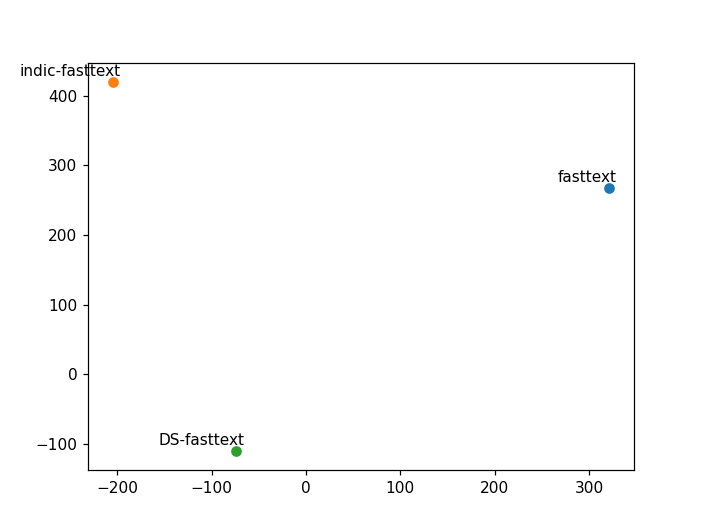

In [28]:
visualize_embeddings(words, embeddings)

In [29]:
for word in intersect:
    embeddings.append(embedding_dict_ft[word])
    words.append("fasttext")
    embeddings.append(embedding_dict_indic[word])
    words.append("indic-fasttext")
    embeddings.append(embedding_dict_ds[word])
    words.append("DS-fasttext")

(15, 2)


<IPython.core.display.Javascript object>


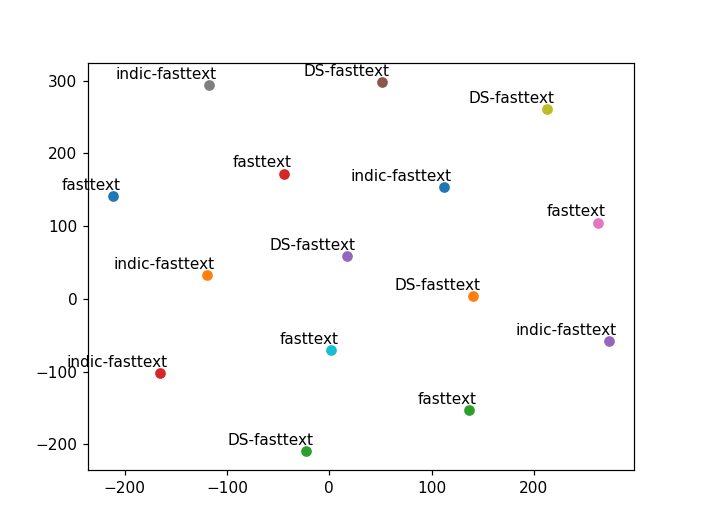

In [30]:
visualize_embeddings(words[:15], embeddings[:15])

In [36]:
def analyze_vocab(vocab_words):
    numbers = []
    english_words = []
    marathi_words = []
    for word in vocab_words:
        #if any(map(str.isdigit, word)):
        if re.match('\d+', word):
            numbers.append(word)
        elif re.match('[a-zA-Z]+', word):
            english_words.append(word)
        else:
            marathi_words.append(word)
    return numbers, english_words, marathi_words

In [37]:
vocab_words = bow_vectorizer.get_feature_names()

In [38]:
print("Total Vocabulary: ", len(vocab_words))
numbers, english_words, marathi_words = analyze_vocab(vocab_words)
print(len(numbers))
print(len(english_words))
print(len(marathi_words))

Total Vocabulary:  51774
17
881
50876


In [40]:
embeddings = []
words = []
for word in numbers:
    embeddings.append(embedding_dict_ds[word])
    words.append("DS-fasttext")

(17, 2)


<IPython.core.display.Javascript object>


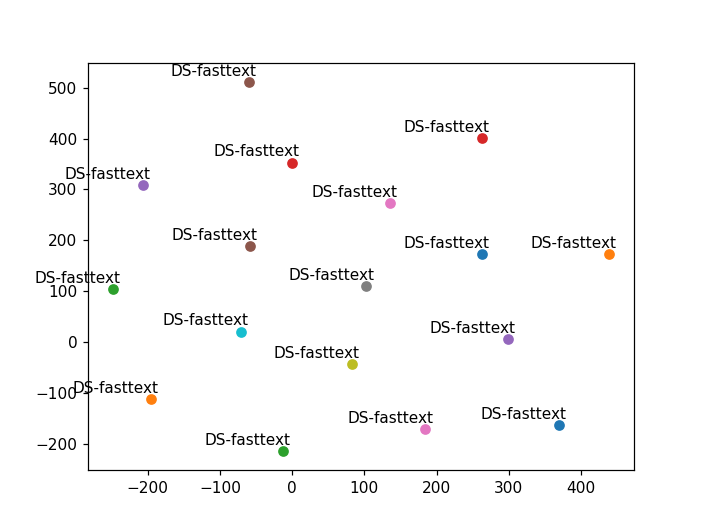

In [41]:
visualize_embeddings(words, embeddings)

In [44]:
char = []
domain = []
reason = []
spcl_words = ['ºC', 'δδ', 'δδt', 'δवाढतो,' 'ε', 'εi', 'ηi', 'ρ', 'σ', 'σD', 'σμ', 'ω']

for text, label in list(zip(x_train, y_train)):
    for x in text.split():
        if x in english_words:
            domain.append(label)
            char.append(x)
            reason.append('english')
        elif x in numbers:
            domain.append(label)
            char.append(x)
            reason.append('number')
        elif x in spcl_words:
            domain.append(label)
            char.append(x)
            reason.append('spcl_char')
        

df = pd.DataFrame(list(zip(reason, char, domain)), columns=['reason', 'char', 'domain'])
df

,reason,char,domain
0,english,z,bioche
1,english,z,bioche
2,english,ram,cse
3,english,p,cse
4,english,unambiguously,cse
...,...,...,...
3704,english,xml,cse
3705,english,linux,cse
3706,english,ms,cse
3707,english,dos,cse


In [45]:
df[df.reason == 'english'].domain.value_counts()

cse         2262
com_tech     861
phy          367
bioche       152
Name: domain, dtype: int64

In [46]:
df[df.reason == 'number'].domain.value_counts()

phy         30
com_tech    15
bioche       2
Name: domain, dtype: int64

In [47]:
df[df.reason == 'spcl_char'].domain.value_counts()

com_tech    9
cse         6
bioche      3
phy         2
Name: domain, dtype: int64

In [72]:
embeddings = []
words = []
temp = df[df.reason == 'spcl_char']
spcl_words = temp[temp.domain == 'cse'].char.values.tolist()

for word in spcl_words:
    embeddings.append(embedding_dict_ds[word])
    words.append(word)
print(len(words))

6


(6, 2)


<IPython.core.display.Javascript object>


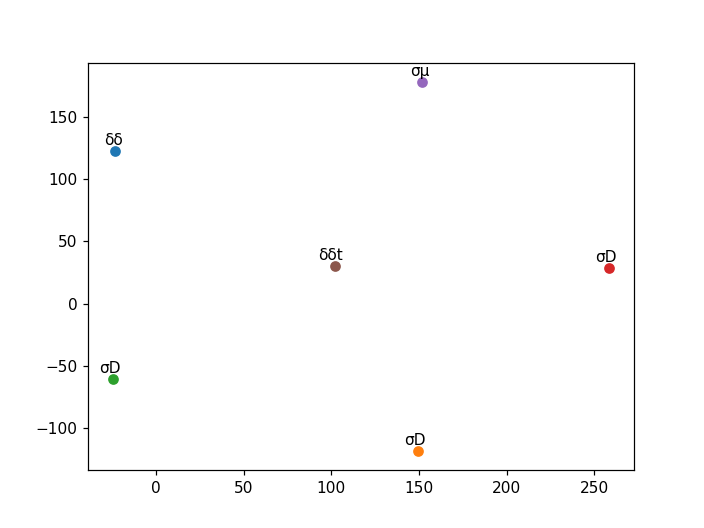

In [73]:
visualize_embeddings(words, embeddings)